In [15]:
import pandas as pd
import numpy as np
from scipy.io import arff
import tensorflow as tf
from tensorflow.keras import layers, backend 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, concatenate, BatchNormalization, LeakyReLU, Flatten
import joblib

import time
from typing import Tuple, List
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [16]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [17]:
def split_df_to_train_val(df, ratio):
    mask = np.random.rand(len(df)) < ratio
    df_train = df[mask]
    df_val = df[~mask]
    return df_train, df_val

In [18]:
diab_arf = arff.loadarff('gdrive/MyDrive/DL/Assignment_4/diabetes.arff')
diab_df = pd.DataFrame(diab_arf[0])
diab_df.replace(to_replace=b'tested_negative', value=-1, inplace=True)
diab_df.replace(to_replace=b'tested_positive', value=1, inplace=True)
# the values must be scaled to the range [-1,1] to match the output of the generator model
def scaler(df):
  for column in df:
    max = df[column].max()
    min = df[column].min()
    col = 2*((df[column] - min)/(max - min)) - 1
    df[column] = col
  return df
diab_df = scaler(diab_df)
diab_df.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,-0.294118,0.487437,0.180328,-0.292929,-1.000000,0.001490,-0.531170,-0.033333,1.0
1,-0.882353,-0.145729,0.081967,-0.414141,-1.000000,-0.207154,-0.766866,-0.666667,-1.0
2,-0.058824,0.839196,0.049180,-1.000000,-1.000000,-0.305514,-0.492741,-0.633333,1.0
3,-0.882353,-0.105528,0.081967,-0.535354,-0.777778,-0.162444,-0.923997,-1.000000,-1.0
4,-1.000000,0.376884,-0.344262,-0.292929,-0.602837,0.284650,0.887276,-0.600000,1.0


In [19]:
df_train, df_test = split_df_to_train_val(diab_df, 0.7)
y_train = df_train.pop('class')
y_test = df_test.pop('class')

df_train.head()

,preg,plas,pres,skin,insu,mass,pedi,age
0,-0.294118,0.487437,0.180328,-0.292929,-1.000000,0.001490,-0.531170,-0.033333
1,-0.882353,-0.145729,0.081967,-0.414141,-1.000000,-0.207154,-0.766866,-0.666667
2,-0.058824,0.839196,0.049180,-1.000000,-1.000000,-0.305514,-0.492741,-0.633333
3,-0.882353,-0.105528,0.081967,-0.535354,-0.777778,-0.162444,-0.923997,-1.000000
5,-0.411765,0.165829,0.213115,-1.000000,-1.000000,-0.236960,-0.894962,-0.700000


In [20]:
# rf.fit(df_train, y_train)
# rf.oob_score_

# using cross-validation and grid-search

# rf = RandomForestClassifier()
# parameters = {
#     'max_features': ('auto', 'sqrt', 10, 12, 20, 30),
#     'max_depth': (5, 10, 15, None),
#     'n_estimators': (100, 200, 500, 1000, 2000)
# }
# gs_rf = GridSearchCV(estimator=rf, param_grid=parameters, cv=5, n_jobs=-1, verbose=3)
# gs_rf.fit(df_train, y_train)

# joblib.dump(gs_rf, "/content/gdrive/MyDrive/DL/Assignment_4/random_forest_diab.joblib")

In [21]:
gs_rf = joblib.load("/content/gdrive/MyDrive/DL/Assignment_4/random_forest_diab.joblib")

In [22]:
gs_rf.best_params_

{'max_depth': 5, 'max_features': 'auto', 'n_estimators': 500}

In [23]:
gs_rf.best_score_

0.7571794871794871

In [24]:
p = gs_rf.predict(df_test)
confusion_matrix(y_test.values, p)

array([[137,  14],
       [ 28,  64]])

In [25]:
print(classification_report(y_test.values, p,labels=[1,-1]))

              precision    recall  f1-score   support

           1       0.82      0.70      0.75        92
          -1       0.83      0.91      0.87       151

    accuracy                           0.83       243
   macro avg       0.83      0.80      0.81       243
weighted avg       0.83      0.83      0.82       243



In [26]:
# joblib.dump(gs_rf, "/content/gdrive/MyDrive/DL/Assignment_4/random_forest_cred.joblib")
# gs_rf = joblib.load("/content/gdrive/MyDrive/DL/Assignment_4/random_forest_cred.joblib")



In [27]:


class GAN:

    def __init__(self, black_box_model):
        self.latent_dim = 10
        self.generator_vector_size = 8
        self.discriminator_input_shape = (self.generator_vector_size,)

        self.generator = self.make_generator_model()
        self.discriminator = self.make_discriminator_model()
        self.gan = self.combime_gan(self.generator, self.discriminator)
        # self.gs_rf = joblib.load("random_forest_diab.joblib")
        self.gs_rf = black_box_model


    def combime_gan(self, g_model, d_model):
        # make weights in the discriminator not trainable
        d_model.trainable = False
        g_input = Input(shape=(self.latent_dim,))
        c_input = Input(shape=(1,))
        g_sample = g_model([g_input, c_input])
        d_desision = d_model([g_sample, c_input, c_input])
        gan_model = Model([g_input, c_input], d_desision)
        opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
        gan_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        return gan_model

    def make_generator_model(self):
        input_noise = Input(shape=(self.latent_dim,))
        c_input = Input(shape=(1,))
        concat_layer_c = concatenate([input_noise, c_input])
        dense_1 = Dense(30, use_bias=True)(concat_layer_c)
        dense_1_bn = BatchNormalization()(dense_1)
        dense_1_lr = LeakyReLU()(dense_1_bn)
        dense_1_do = Dropout(0.2)(dense_1_lr)
        dense_2 = Dense(15)(dense_1_do)
        dense_2_bn = BatchNormalization()(dense_2)
        dense_2_lr = LeakyReLU()(dense_2_bn)
        dense_2_do = Dropout(0.2)(dense_2_lr)
        final_layer = Dense(self.generator_vector_size, activation='tanh')(dense_2_do)
        # concat_layer = concatenate([final_layer, c_input])
        model = Model(inputs=[input_noise, c_input], outputs=final_layer)

        model.summary()
        return model

    def make_discriminator_model(self):

        # input_sample = Input(shape=self.discriminator_input_shape,)
        input_sample = Input(shape=self.discriminator_input_shape)
        cy1_input = Input(shape=(1,))
        cy2_input = Input(shape=(1,))

        concat_layer_c = concatenate([input_sample, cy1_input, cy2_input])
        dense_1 = Dense(32, use_bias=True)(concat_layer_c)
        dense_1_lr = LeakyReLU()(dense_1)
        dense_1_do = Dropout(0.2)(dense_1_lr)
        dense_2 = Dense(16)(dense_1_do)
        dense_2_lr = LeakyReLU()(dense_2)
        dense_2_do = Dropout(0.2)(dense_2_lr)
        flatten = Flatten()(dense_2_do)
        final_layer = Dense(1, activation='sigmoid')(flatten)
        model = Model(inputs=[input_sample, cy1_input, cy2_input], outputs=final_layer)
        # opt = tf.keras.optimizers.Adam(lr=0.00015, beta_1=0.5)
        opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        model.summary()
        return model

    def generate_real_x_y(self, n_samples: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        # prepare samples
        noise = np.random.uniform(-1, 1, size=(n_samples, self.latent_dim))
        c_1 = np.random.random((n_samples, ))
        samples_1 = self.generator.predict([noise, c_1])
        y_1 = self.gs_rf.predict_proba(samples_1)[:, 0]
        valid = np.ones((n_samples, 1))
        return samples_1, c_1, y_1, valid

    def generate_fake_x_y(self, n_samples: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        noise = np.random.uniform(-1, 1, size=(n_samples, self.latent_dim))
        c_2 = np.random.random((n_samples, ))
        samples_2 = self.generator.predict([noise, c_2])
        y_2 = self.gs_rf.predict_proba(samples_2)[:, 0]
        invalid = np.zeros((n_samples, 1))
        return samples_2, y_2, c_2, invalid

    def train(self, epochs, batch_size=8):
        # (X_train, _), (_, _) = mnist.load_data()
        # X_train = X_train / 127.5 - 1.
        # X_train = np.expand_dims(X_train, axis=3)
        # X_train = df.values
        valid = np.ones((batch_size, 1))
        invalid = np.zeros((batch_size, 1))
        valid_twice = np.ones((batch_size * 2, 1))
        # fake = np.zeros((batch_size, 1))
        d_losses = np.zeros((epochs, 1))
        d_accuracies = np.zeros((epochs, 1))
        d_fake_losses = np.zeros((epochs, 1))
        d_fake_accuracies = np.zeros((epochs, 1))
        d_real_losses = np.zeros((epochs, 1))
        d_real_accuracies = np.zeros((epochs, 1))
        g_losses = np.zeros((epochs, 1))
        g_accuracies = np.zeros((epochs, 1))
        best_epoch = 0

        d_acc_delta_to_0_5 = 1
        losses_delta = 1
        real_2_fake_acc_delta = 1
        for i, epoch in enumerate(range(epochs)):
            # prepare samples
            noise = np.random.uniform(-1, 1, size=(batch_size, self.latent_dim))
            c_1 = np.random.random((batch_size, ))
            samples_1 = self.generator.predict([noise, c_1])
            y_1 = self.gs_rf.predict_proba(samples_1)[:, 0]  # evaluate Y via RF classifier take first column confidence
            c_2 = np.random.random((batch_size, ))
            samples_2 = self.generator.predict([noise, c_2])
            y_2 = self.gs_rf.predict_proba(samples_2)[:, 0]  # evaluate Y via RF classifier take first column confidence

            # create training set for the discriminator
            # swapping places between 'y' and 'c' trains the Discriminator
            # to realize that right hand side parameter is fake (and the opposite)
            samples, c, y_bb = np.vstack((samples_1, samples_2)), np.concatenate((c_1, y_2), axis=None), np.concatenate((y_1, c_2), axis=None)
            # samples, c, y_bb = np.vstack((samples_1, samples_2)), np.vstack((c_1, y_2)), np.vstack((y_1, c_2))

            # update discriminator model weights
            d_loss, d_acc = self.discriminator.train_on_batch([samples, c, y_bb], np.vstack((valid, invalid)))

            # evaluate discriminator on real examples
            samples_real, c_real, y_bb_real, y_real = self.generate_real_x_y(batch_size)
            d_loss_real, d_acc_real = self.discriminator.evaluate([samples_real, c_real, y_bb_real], y_real, verbose=0)
            # evaluate discriminator on fake examples
            samples_fake, c_fake, y_bb_fake, y_fake = self.generate_fake_x_y(batch_size)
            d_loss_fake, d_acc_fake = self.discriminator.evaluate([samples_fake, c_fake, y_bb_fake], y_fake, verbose=0)

            d_fake_losses[i] = d_loss_fake
            d_real_losses[i] = d_loss_real
            d_fake_accuracies[i] = d_acc_fake
            d_real_accuracies[i] = d_acc_real

            # create inverted labels for the fake samples so generator can improve to be 'real'
            # update the generator via the discriminator's error
            noise = np.random.uniform(-1, 1, size=(batch_size * 2, self.latent_dim))
            c = np.random.normal(0, 1, (batch_size * 2, ))
            g_loss, g_acc = self.gan.train_on_batch([noise, c], valid_twice)

            d_losses[i] = d_loss
            d_accuracies[i] = d_acc
            g_losses[i] = g_loss
            g_accuracies[i] = g_acc

            # if i % 50 == 0:
            #     print("epoch %d [D loss: %f, acc.: %.2f%%] [G loss: %f, acc.: %.2f%%]" % (epoch, d_loss, 100 * d_acc, g_loss, g_acc))
            #     if 800 <= i:
            #         if abs(g_loss - d_loss) < losses_delta: # check that losses converged
            #             if d_acc_delta_to_0_5 > abs(d_acc - 0.5) and real_2_fake_acc_delta > abs( d_acc_fake - d_acc_real): # save generator model for closest to 0.5 accuracy
            #                 losses_delta = abs(g_loss - d_loss)
            #                 d_acc_delta_to_0_5 = abs(d_acc - 0.5)
            #                 real_2_fake_acc_delta = abs(d_fake_accuracies - d_real_accuracies)
            #                 filename = 'generator_model.h5'
            #                 self.generator.save(filename)
            #                 best_epoch = epoch

            if i % 50 == 0:
                print("epoch %d [D loss: %f, acc.: %.2f%%] [G loss: %f, acc.: %.2f%%]" % (epoch, d_loss, 100 * d_acc, g_loss, g_acc))
                if 800 <= i:
                    if abs(g_loss - d_loss) < 0.1: # check that losses converged
                        if abs(d_acc - 0.5) < 0.1 and abs( d_acc_fake - d_acc_real) < 0.1 : # save generator model for closest to 0.5 accuracy
                            # filename = 'generator_model.h5'
                            filename = 'generator_model_%03d.h5' % epoch

                            self.generator.save(filename)
                            best_epoch = epoch       

        print(f'Best epoch: {best_epoch}')
        return d_losses, d_accuracies, g_losses, g_accuracies, d_fake_losses, d_real_losses, d_fake_accuracies, d_real_accuracies

In [28]:
iterations = 3500
gan = GAN(gs_rf)
# d_losses, d_accuracies, g_losses, g_accuracies = gan.train(epochs=iterations, batch_size=16)
d_losses, d_accuracies, g_losses, g_accuracies, d_fake_losses, d_real_losses, d_fake_accuracies, d_real_accuracies = gan.train(epochs=iterations, batch_size=16)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 11)           0           input_8[0][0]                    
                                                                 input_9[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 30)           360         concatenate_2[0][0]        

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


epoch 0 [D loss: 0.715245, acc.: 43.75%] [G loss: 0.622383, acc.: 0.72%]
epoch 50 [D loss: 0.706564, acc.: 41.67%] [G loss: 0.660536, acc.: 0.66%]
epoch 100 [D loss: 0.687883, acc.: 52.08%] [G loss: 0.655968, acc.: 0.66%]
epoch 150 [D loss: 0.710320, acc.: 41.67%] [G loss: 0.647529, acc.: 0.72%]
epoch 200 [D loss: 0.701342, acc.: 43.75%] [G loss: 0.659534, acc.: 0.62%]
epoch 250 [D loss: 0.701286, acc.: 47.92%] [G loss: 0.642662, acc.: 0.66%]
epoch 300 [D loss: 0.707149, acc.: 43.75%] [G loss: 0.690418, acc.: 0.53%]
epoch 350 [D loss: 0.695735, acc.: 50.00%] [G loss: 0.697556, acc.: 0.50%]
epoch 400 [D loss: 0.700043, acc.: 41.67%] [G loss: 0.698496, acc.: 0.50%]
epoch 450 [D loss: 0.681768, acc.: 66.67%] [G loss: 0.687556, acc.: 0.56%]
epoch 500 [D loss: 0.695710, acc.: 43.75%] [G loss: 0.664671, acc.: 0.66%]
epoch 550 [D loss: 0.693221, acc.: 58.33%] [G loss: 0.708762, acc.: 0.50%]
epoch 600 [D loss: 0.672861, acc.: 54.17%] [G loss: 0.689501, acc.: 0.53%]
epoch 650 [D loss: 0.667326,

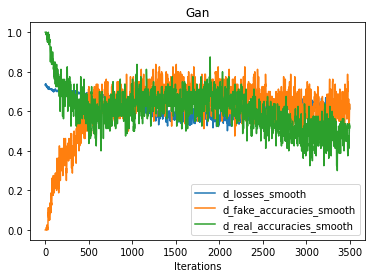

In [29]:
from typing import List

def plot_metric_general(graphs: List[np.ndarray], labels: List[str]) -> None:
    import matplotlib.pyplot as plt
    epochs = range(1, graphs[0].shape[0] + 1)
    plt.xlabel("Iterations")
    plt.title('Gan')
    for i in range(len(labels)):
        plt.plot(epochs, graphs[i])
    plt.legend(labels)
    plt.show()

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

d_losses_smooth, d_fake_accuracies_smooth, d_real_accuracies_smooth = moving_average(d_losses.reshape((iterations)), 5), moving_average(d_fake_accuracies.reshape((iterations)), 5), moving_average(d_real_accuracies.reshape((iterations)), 5)

plot_metric_general([d_losses_smooth, d_fake_accuracies_smooth, d_real_accuracies_smooth], ['d_losses_smooth', 'd_fake_accuracies_smooth', 'd_real_accuracies_smooth'])
# plot_metric_general([d_losses, d_accuracies, g_losses, g_accuracies], ['d_losses', 'd_accuracies', 'g_losses', 'g_accuracies']) 
# we can see aroud 800 epochs d_fake_accuracies=d_real_accuracies=0.5 and after that it degragates 

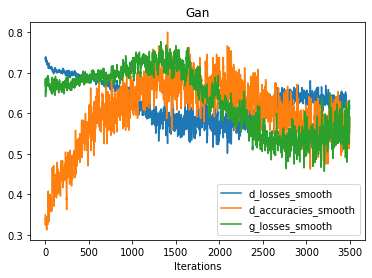

In [30]:
d_losses_smooth, d_accuracies_smooth, g_losses_smooth, g_accuracies_smooth = moving_average(d_losses.reshape((iterations)), 5), moving_average(d_accuracies.reshape((iterations)), 5), moving_average(g_losses.reshape((iterations)), 5), moving_average(g_accuracies.reshape((iterations)), 5)

plot_metric_general([d_losses_smooth, d_accuracies_smooth, g_losses_smooth], ['d_losses_smooth', 'd_accuracies_smooth', 'g_losses_smooth'])

In [31]:
import seaborn as sns
sns.set_theme()

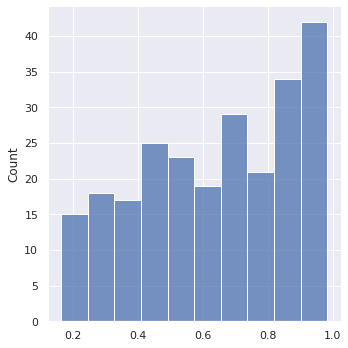

In [32]:
p_proba = gs_rf.predict_proba(df_test)[:,0]
sns.displot(p_proba, bins=10)

In [33]:
print(f'min {min(p_proba)}, max {max(p_proba)}, avg {sum(p_proba)/len(p_proba)}')

min 0.16437916595696844, max 0.9832781989358225, avg 0.6380105573088423


In [49]:
smaples_len = 1000
noise = np.random.uniform(-1, 1, size=(smaples_len, 10))
c = np.random.uniform(size=(smaples_len, ))
loaded_generator = tf.keras.models.load_model('generator_model_2100.h5')
# samples = gan.generator.predict([noise, c])
samples = loaded_generator.predict([noise, c])

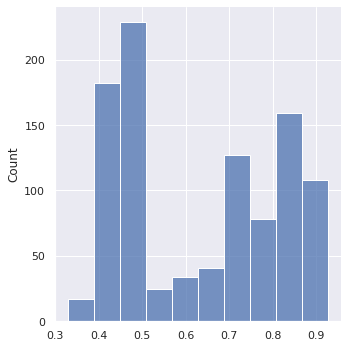

In [50]:
p_proba_s = gs_rf.predict_proba(samples)[:,0]
sns.displot(p_proba_s, bins=10)

In [51]:
print(f'min {min(p_proba_s)}, max {max(p_proba_s)}, avg {sum(p_proba_s)/len(p_proba_s)}')

min 0.3287434047365515, max 0.928045728588254, avg 0.633922940636928


In [ ]:
# will be a little bit hard to explain... the distribution is not the same at all.
# got various different results from a couple of runs
# for sure one of the other architecures will give a better results